In [1]:
!unzip -qq archive_2.zip

In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("./archive/train/train/")
new_base_dir = pathlib.Path("./cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [5]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [7]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [8]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [9]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [10]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [11]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 15s 87ms/step - loss: 0.7461 - accuracy: 0.5200 - val_loss: 0.6907 - val_accuracy: 0.5030
Epoch 2/30
63/63 [==============================] - 5s 73ms/step - loss: 0.7097 - accuracy: 0.5815 - val_loss: 0.6614 - val_accuracy: 0.6250
Epoch 3/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6768 - accuracy: 0.6050 - val_loss: 0.6765 - val_accuracy: 0.5660
Epoch 4/30
63/63 [==============================] - 5s 75ms/step - loss: 0.6699 - accuracy: 0.6405 - val_loss: 0.6470 - val_accuracy: 0.6290
Epoch 5/30
63/63 [==============================] - 5s 74ms/step - loss: 0.6163 - accuracy: 0.6835 - val_loss: 0.6274 - val_accuracy: 0.6540
Epoch 6/30
63/63 [==============================] - 5s 75ms/step - loss: 0.5546 - accuracy: 0.7165 - val_loss: 0.6185 - val_accuracy: 0.6780
Epoch 7/30
63/63 [==============================] - 5s 75ms/step - loss: 0.5525 - accuracy: 0.7315 - val_loss: 0.6120 - val_accuracy: 0.7030
Epoch 8/30
6

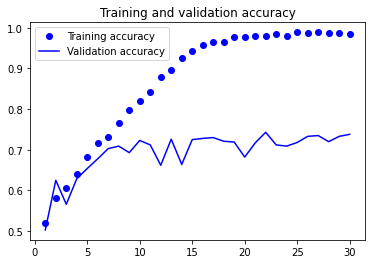

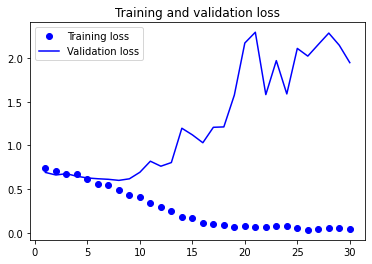

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [14]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 36ms/step - loss: 0.6545 - accuracy: 0.6740
Test accuracy: 0.674


In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

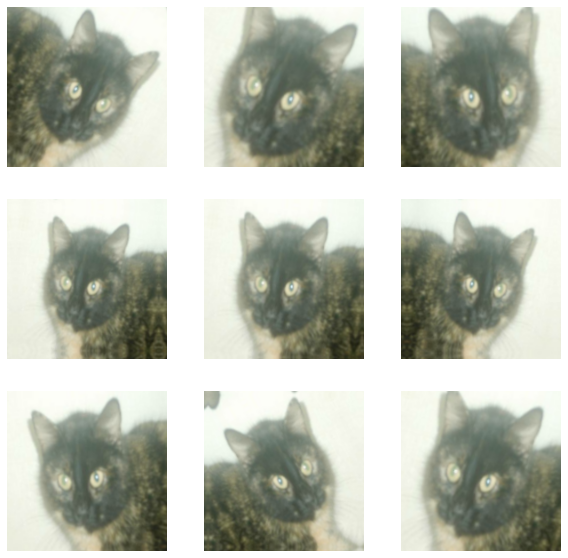

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [17]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 8s 100ms/step - loss: 0.7114 - accuracy: 0.5060 - val_loss: 0.6893 - val_accuracy: 0.5800
Epoch 2/100
63/63 [==============================] - 6s 99ms/step - loss: 0.6937 - accuracy: 0.5500 - val_loss: 0.6859 - val_accuracy: 0.5110
Epoch 3/100
63/63 [==============================] - 6s 98ms/step - loss: 0.6827 - accuracy: 0.5815 - val_loss: 0.6582 - val_accuracy: 0.5980
Epoch 4/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6778 - accuracy: 0.6075 - val_loss: 0.6479 - val_accuracy: 0.6160
Epoch 5/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6579 - accuracy: 0.6235 - val_loss: 0.6584 - val_accuracy: 0.6010
Epoch 6/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6382 - accuracy: 0.6500 - val_loss: 0.6147 - val_accuracy: 0.6450
Epoch 7/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6266 - accuracy: 0.6560 - val_loss: 0.6651 - val_accuracy: 0.5810
Epoch

In [19]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 35ms/step - loss: 0.4729 - accuracy: 0.8340
Test accuracy: 0.834


In [20]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [21]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 18ms/step


In [22]:
train_features.shape

(2000, 5, 5, 512)

In [23]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 24.2104 - accuracy: 0.9195 - val_loss: 3.3285 - val_accuracy: 0.9750
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 3.4370 - accuracy: 0.9760 - val_loss: 5.5854 - val_accuracy: 0.9660
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2.1835 - accuracy: 0.9825 - val_loss: 5.5949 - val_accuracy: 0.9730
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.4872 - accuracy: 0.9880 - val_loss: 6.7245 - val_accuracy: 0.9710
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6834 - accuracy: 0.9935 - val_loss: 4.0180 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.8711 - accuracy: 0.9945 - val_loss: 4.4700 - val_accuracy: 0.9750
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 4.0560e-05 - accuracy: 1.0000 - val_loss: 4.8604 - val_accuracy: 0.9730
Epoch 8/20
63/

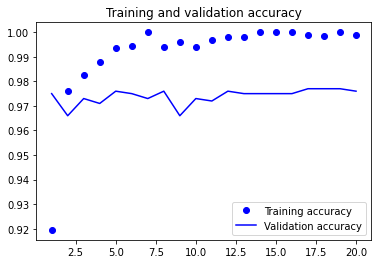

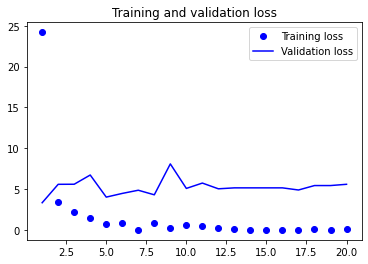

In [24]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [25]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [26]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [27]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 15s 215ms/step - loss: 16.3567 - accuracy: 0.9030 - val_loss: 5.1631 - val_accuracy: 0.9610
Epoch 2/50
63/63 [==============================] - 13s 209ms/step - loss: 8.6096 - accuracy: 0.9400 - val_loss: 13.0019 - val_accuracy: 0.9360
Epoch 3/50
63/63 [==============================] - 14s 213ms/step - loss: 5.5919 - accuracy: 0.9545 - val_loss: 4.3313 - val_accuracy: 0.9680
Epoch 4/50
63/63 [==============================] - 14s 214ms/step - loss: 4.2402 - accuracy: 0.9665 - val_loss: 3.5731 - val_accuracy: 0.9720
Epoch 5/50
63/63 [==============================] - 13s 209ms/step - loss: 3.5905 - accuracy: 0.9675 - val_loss: 6.7159 - val_accuracy: 0.9660
Epoch 6/50
63/63 [==============================] - 14s 213ms/step - loss: 3.6619 - accuracy: 0.9650 - val_loss: 2.6438 - val_accuracy: 0.9780
Epoch 7/50
63/63 [==============================] - 13s 210ms/step - loss: 3.9829 - accuracy: 0.9695 - val_loss: 6.6765 - val_accuracy: 0.96

In [30]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 117ms/step - loss: 1.6707 - accuracy: 0.9790
Test accuracy: 0.979


In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [32]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [33]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 236ms/step - loss: 0.6439 - accuracy: 0.9900 - val_loss: 2.7385 - val_accuracy: 0.9770
Epoch 2/30
63/63 [==============================] - 15s 233ms/step - loss: 0.2340 - accuracy: 0.9925 - val_loss: 2.3353 - val_accuracy: 0.9810
Epoch 3/30
63/63 [==============================] - 15s 228ms/step - loss: 0.6052 - accuracy: 0.9875 - val_loss: 2.3553 - val_accuracy: 0.9810
Epoch 4/30
63/63 [==============================] - 15s 231ms/step - loss: 0.5387 - accuracy: 0.9910 - val_loss: 2.2907 - val_accuracy: 0.9790
Epoch 5/30
63/63 [==============================] - 15s 227ms/step - loss: 0.4092 - accuracy: 0.9895 - val_loss: 2.3360 - val_accuracy: 0.9810
Epoch 6/30
63/63 [==============================] - 15s 231ms/step - loss: 0.1471 - accuracy: 0.9950 - val_loss: 2.1491 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - 15s 234ms/step - loss: 0.4402 - accuracy: 0.9885 - val_loss: 2.0435 - val_accuracy: 0.9810

In [34]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 116ms/step - loss: 1.6170 - accuracy: 0.9790
Test accuracy: 0.979
